In [1]:
# export $(cat .env | xargs)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
print(sys.executable)

/home/mle-user/env_recsys_start/bin/python3.10


# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [4]:
import gc
import os
import boto3
import joblib

import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import sklearn.preprocessing
from implicit.als import AlternatingLeastSquares

from catboost import CatBoostClassifier, Pool

/home/mle-user/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
s3_endpoint_url = "https://storage.yandexcloud.net" 
aws_access_key_id = os.environ['AWS_ACCESS_KEY_ID']
aws_secret_access_key = os.environ['AWS_SECRET_ACCESS_KEY']
aws_bucket_name = os.environ['S3_BUCKET_NAME']

s3_recsys_path = "recsys/data/"

In [7]:
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)
s3_client = session.client('s3', endpoint_url = s3_endpoint_url)

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [9]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

Данные

Данные находятся в трёх файлах.

Данные о треках — в файле tracks.parquet:

track_id — идентификатор музыкального трека;

albums — список идентификаторов альбомов, содержащих трек;

artists — список идентификаторов исполнителей трека;

genres — список идентификаторов жанров, к которым принадлежит трек.




Имена артистов, названия альбомов, треков и жанров — в файле catalog_names.parquet:

id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);

type — тип идентификатора;

name — имя (название) каталожной единицы.




Данные о том, какие пользователи прослушали тот или иной трек, — в файле interactions.parquet :

user_id — идентификатор пользователя,

track_id — идентификатор музыкального трека,

track_seq — номер места трека в истории пользователя,

started_at — дата начала прослушивания трека.

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [10]:
# Нужно ли изменить тип идентификаторов?

In [11]:
# типы данных
print(tracks.dtypes)
print(catalog_names.dtypes)
print(interactions.dtypes)

track_id     int64
albums      object
artists     object
genres      object
dtype: object
id       int64
type    object
name    object
dtype: object
user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object


In [12]:
# типы track_id из разных таблиц сatalog track interactions
tracks_in_catalog = set(catalog_names[catalog_names['type'] == 'track']['id'])
tracks_in_tracks = set(tracks['track_id'])
tracks_in_interactions = set(interactions['track_id'])

print(len(tracks_in_catalog))
print(len(tracks_in_tracks))
print(len(tracks_in_interactions))

print(len(tracks_in_catalog.union(tracks_in_tracks).union(tracks_in_interactions)))

# такие ID отсутствуют
# так объединение всех источников с track_id совпадает с исходным количеством уникальных track_id в отедльных источниках
# то
# 1 все track_id одинаковые во всех таблицах
# 2 все типы track_id одинаковые

1000000
1000000
1000000
1000000


In [13]:
albums_in_tracks = set()
for list_alb in tracks['albums']:
    albums_in_tracks.update(list_alb)

albums_in_catalog = set(catalog_names[catalog_names['type'] == 'album']['id'])

print(len(albums_in_tracks))
print(len(albums_in_catalog))

print(len(albums_in_tracks.union(albums_in_catalog)))

# такие ID отсутствуют
# так объединение всех источников с album_id совпадает с исходным количеством уникальных album_id в отедльных источниках
# то
# 1 все album_id одинаковые во всех таблицах
# 2 все типы album_id одинаковые

658724
658724
658724


In [14]:
artists_in_tracks = set()
for list_art in tracks['artists']:
    artists_in_tracks.update(list_art)

artists_in_catalog = set(catalog_names[catalog_names['type'] == 'artist']['id'])

print(len(artists_in_tracks))
print(len(artists_in_catalog))

print(len(artists_in_tracks.union(artists_in_catalog)))

# такие ID отсутствуют
# так объединение всех источников с artist_id совпадает с исходным количеством уникальных artist_id в отедльных источниках
# то
# 1 все artist_id одинаковые во всех таблицах
# 2 все типы artist_id одинаковые

153581
153581
153581


In [15]:
genres_in_tracks = set()
for list_gen in tracks['genres']:
    genres_in_tracks.update(list_gen)

genres_in_catalog = set(catalog_names[catalog_names['type'] == 'genre']['id'])

print(len(genres_in_tracks))
print(len(genres_in_catalog))

print(len(genres_in_tracks.union(genres_in_catalog)))

# так объединение всех источников с genre_id не совпадает с исходным количеством уникальных genre_id в отедльных источниках
print({type(item).__name__ for item in genres_in_tracks})
print({type(item).__name__ for item in genres_in_catalog})
# типы совпадают

173
166
196
{'int64'}
{'int'}


In [16]:
# Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

In [17]:
print('кол-во треков без альбома = ',  tracks[ tracks.albums.apply(lambda x : len(x)) == 0 ].shape ) 
print('кол-во треков без артиста = ', tracks[ tracks.artists.apply(lambda x : len(x)) == 0 ].shape )
print('кол-во треков без жанра = ', tracks[ tracks.genres.apply(lambda x : len(x)) == 0 ].shape )

кол-во треков без альбома =  (18, 4)
кол-во треков без артиста =  (15369, 4)
кол-во треков без жанра =  (3687, 4)


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [18]:
# количество уникальных жанров а таблице tracks не совпадает с уникальным количеством в catalog_names. Пока с этим ничего не будем делать
# есть треки без альбомов, артиство и без жанров. Пока с этим тоже ничего не будем делать

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

<Axes: xlabel='id трека', ylabel='кол-во прослушиваний'>

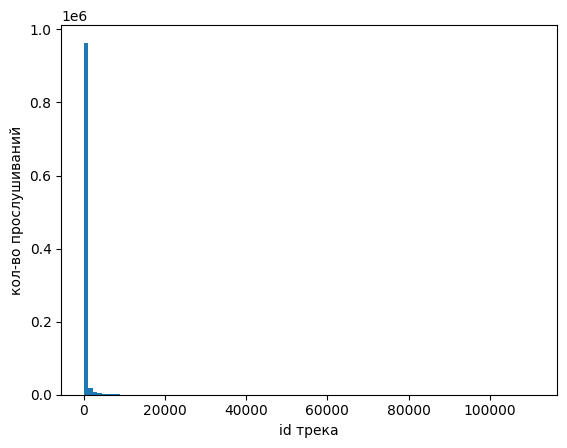

In [19]:
interactions['track_id'].value_counts().plot.hist(bins = 100 , xlabel = 'id трека', ylabel = 'кол-во прослушиваний')

Наиболее популярные треки

In [20]:
interactions['track_id'].value_counts().reset_index().merge(catalog_names[catalog_names.type == 'track'], how = 'left', left_on = 'track_id', right_on = 'id')

,track_id,count,id,type,name
0,53404,111062,53404,track,Smells Like Teen Spirit
1,33311009,106921,33311009,track,Believer
2,178529,101924,178529,track,Numb
3,35505245,99490,35505245,track,I Got Love
4,65851540,86670,65851540,track,Юность
...,...,...,...,...,...
999995,44212057,5,44212057,track,Good Life
999996,67688588,5,67688588,track,Насвай
999997,15626369,5,15626369,track,Qosbasar
999998,44125112,5,44125112,track,Cygnus X-1 Book II: Hemispheres


Наиболее популярные жанры

In [22]:
pop_genres = tracks.explode('genres')[['track_id', 'genres']]
gc.collect()

0

In [23]:

pop_genres = interactions[['track_id', 'user_id']].set_index('track_id').join( pop_genres.set_index('track_id') , how = 'left')
gc.collect()

0

In [24]:
pop_genres = pop_genres.reset_index()

In [26]:
pop_genres = pop_genres.genres.value_counts().reset_index()
gc.collect()
pop_genres = pop_genres.merge(catalog_names[catalog_names.type == 'genre'], how = 'left', left_on = 'genres', right_on = 'id')
gc.collect()

0

In [28]:
pop_genres

,genres,count,id,type,name
0,11,55578312,11.0,genre,pop
1,75,37799821,75.0,genre,rap
2,102,31092013,102.0,genre,allrock
3,20,26626241,20.0,genre,ruspop
4,3,25303695,3.0,genre,rusrap
...,...,...,...,...,...
168,166,207,NaN,NaN,NaN
169,106,61,106.0,genre,technologies
170,148,54,NaN,NaN,NaN
171,124,30,NaN,NaN,NaN


Треки, которые никто не прослушал

In [29]:
tracks[~tracks.track_id.isin(interactions['track_id'])]
# нет таких треков

,track_id,albums,artists,genres


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [30]:
# больше двух треков 
user_track_count = interactions[['user_id', 'track_id']].groupby('user_id').agg(nunique_track_id = ('track_id', 'nunique')).reset_index()
user_track_count = user_track_count[user_track_count['nunique_track_id'] > 1]

In [31]:
interactions = interactions[interactions.user_id.isin(user_track_count.user_id)]

In [32]:
del interactions['track_seq']

In [33]:
interactions = interactions.rename(columns = {'track_id': 'item_id'})
tracks = tracks.rename(columns = {'track_id': 'item_id'})

In [34]:
interactions

,user_id,item_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22
...,...,...,...
287,1374582,95514767,2022-12-29
288,1374582,97220301,2022-12-29
289,1374582,97241171,2022-12-29
290,1374582,98542641,2022-12-29


In [35]:
tracks

,item_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


In [36]:
tracks.to_parquet('items.parquet')
interactions.to_parquet('events.parquet')

In [38]:
s3_client.upload_file(
            Filename = 'items.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}items.parquet'
        )

s3_client.upload_file(
            Filename = 'events.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}events.parquet'
        )

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [39]:
del tracks
del catalog_names
del interactions
del pop_genres
del user_track_count

In [42]:
gc.collect()

0

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [8]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [ ]:
interactions = pd.read_parquet('interactions.parquet')

In [ ]:
interactions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Non-Null Count      Dtype         
---  ------      --------------      -----         
 0   user_id     222629898 non-null  int32         
 1   track_id    222629898 non-null  int32         
 2   track_seq   222629898 non-null  int16         
 3   started_at  222629898 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [ ]:
222629898
208730442
13898607

In [9]:
split_date = pd.to_datetime("2022-12-16")

events_train = events[events["started_at"] < split_date]
events_test = events[events["started_at"] >= split_date]

In [10]:
print('количество событий в train = ', events_train.shape)
print('количество событий в test = ',events_test.shape)

print('количество user_id в train = ',events_train.drop_duplicates(subset = 'user_id').shape)
print('количество user_id в train = ',events_test.drop_duplicates(subset = 'user_id').shape)

количество событий в train =  (208730442, 3)
количество событий в test =  (13898607, 3)
количество user_id в train =  (1341756, 3)
количество user_id в train =  (783486, 3)


In [12]:
events_train.to_parquet('events_train.parquet')
events_test.to_parquet('events_test.parquet')

s3_client.upload_file(
            Filename = 'events_train.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}events_train.parquet'
        )

s3_client.upload_file(
            Filename = 'events_test.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}events_test.parquet'
        )

In [13]:
del events

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [18]:
catalog_names = pd.read_parquet('catalog_names.parquet')

In [19]:
top_popular = events_train['item_id'].value_counts().reset_index().merge(catalog_names[catalog_names.type == 'track'], how = 'left', left_on = 'item_id', right_on = 'id')
top_popular = top_popular.sort_values(by = 'count', ascending = False)# [:100]

In [20]:
top_popular.head()

,item_id,count,id,type,name
0,53404,110025,53404,track,Smells Like Teen Spirit
1,33311009,101075,33311009,track,Believer
2,178529,100866,178529,track,Numb
3,35505245,95523,35505245,track,I Got Love
4,24692821,84153,24692821,track,Way Down We Go


In [21]:
top_popular.to_parquet("top_popular.parquet")

s3_client.upload_file(
            Filename = 'top_popular.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}top_popular.parquet'
        )

In [25]:
del catalog_names

NameError: name 'catalog_names' is not defined

# Персональные

Рассчитаем персональные рекомендации.

In [45]:
events = pd.read_parquet("events.parquet", columns = ['user_id'])
items = pd.read_parquet("items.parquet", columns = ['item_id'])
events_train = pd.read_parquet('events_train.parquet')
events_test = pd.read_parquet('events_test.parquet')

In [46]:
%%time

user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"]) 
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

CPU times: user 59.4 s, sys: 3.07 s, total: 1min 2s
Wall time: 1min 2s


In [47]:
%%time

events_train['target'] = 1

user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train['target'],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

CPU times: user 2.99 s, sys: 824 ms, total: 3.82 s
Wall time: 3.82 s


In [ ]:
# %%time

# sparse.save_npz("user_item_matrix_train.npz", user_item_matrix_train)

CPU times: user 50.5 s, sys: 428 ms, total: 50.9 s
Wall time: 54 s


In [49]:
user_item_matrix_train = sparse.load_npz("user_item_matrix_train.npz")

In [50]:
del events_train
del events_test
del items
del events

In [51]:
# чтобы не запусить переобучение
als_model = AlternatingLeastSquares(factors=10, iterations=10, regularization=0.05, random_state=42)
als_model.fit(user_item_matrix_train)

100%|██████████| 10/10 [04:15<00:00, 25.54s/it]


In [85]:
gc.collect()

577

In [ ]:
# with open('models/als_model.pkl', 'wb') as file:
#     joblib.dump(als_model, file)

In [54]:
with open('models/als_model.pkl', 'rb') as file:
    als_model = joblib.load(file)

In [86]:
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 208730442 stored elements and shape (1372372, 1000000)>

In [59]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"item_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["item_id"] = item_encoder.inverse_transform(recommendations["item_id_enc"])
    
    return recommendations

In [87]:
user_id = 1372371
get_recommendations_als(
    user_item_matrix=user_item_matrix_train,
    model=als_model,
    user_id=user_id,
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    include_seen=False,
    n=5
)

,item_id_enc,score,item_id
0,83145,0.070943,732401
1,59925,0.069478,580880
2,58621,0.067113,560473
3,137673,0.064399,2758009
4,90461,0.063077,795836


In [88]:
%%time

# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_) )

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=10)

CPU times: user 1h 33min 50s, sys: 1h 6min 9s, total: 2h 39min 59s
Wall time: 41min 28s


In [89]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

In [90]:
als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})

In [91]:
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

In [92]:
# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

In [93]:
# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [94]:
als_recommendations.to_parquet("als_recommendations.parquet")

s3_client.upload_file(
            Filename = 'als_recommendations.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}als_recommendations.parquet'
        )

In [95]:
gc.collect()

553

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [108]:
%%time

item_ids_encoded = range(len(item_encoder.classes_) )

als_similar = als_model.similar_items(
    item_ids_encoded,  N=11) # так как сам себя возращает, если хотим найти 10 похожих то берем 11

CPU times: user 1h 22min 23s, sys: 1h 6min 6s, total: 2h 28min 29s
Wall time: 39min 47s


In [109]:
similar_item_ids_enc = als_similar[0]
similar_als_scores = als_similar[1]

In [110]:
als_similar = pd.DataFrame({
    "item_id_enc": item_ids_encoded,
    "rec_item_id_enc": similar_item_ids_enc.tolist(), 
    "score": similar_als_scores.tolist()})

In [111]:
als_similar = als_similar.explode(["rec_item_id_enc", "score"], ignore_index=True)

In [112]:
als_similar["item_id_enc"] = als_similar["item_id_enc"].astype("int")
als_similar["rec_item_id_enc"] = als_similar["rec_item_id_enc"].astype("int")
als_similar["score"] = als_similar["score"].astype("float")

In [113]:
als_similar["item_id"] = item_encoder.inverse_transform(als_similar["item_id_enc"])
als_similar["rec_item_id"] = item_encoder.inverse_transform(als_similar["rec_item_id_enc"])
als_similar = als_similar.drop(columns=["item_id_enc", "rec_item_id_enc"])

In [114]:
als_similar.to_parquet("als_similar.parquet")

s3_client.upload_file(
            Filename = 'als_similar.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}als_similar.parquet'
        )

In [116]:
als_similar

,score,item_id,rec_item_id
0,1.000000,26,26
1,0.964777,26,1704328
2,0.964728,26,10851471
3,0.963184,26,2163978
4,0.959817,26,560452
...,...,...,...
10999995,0.971645,101521819,70626416
10999996,0.968042,101521819,85659885
10999997,0.962324,101521819,78094473
10999998,0.962320,101521819,87856142


In [117]:
del als_similar
del als_recommendations

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [9]:
# посчитаем самые популярные жанры на трейне 

In [8]:
pop_genres = pd.read_parquet('tracks.parquet', columns= ['track_id', 'genres'])
pop_genres = pop_genres.rename(columns={'track_id': 'item_id'})
events_train = pd.read_parquet('events_train.parquet', columns= ['user_id', 'item_id'])

In [11]:
pop_genres = pop_genres.explode('genres')[['item_id', 'genres']]
gc.collect()

0

In [12]:
pop_genres = events_train[['item_id', 'user_id']].set_index('item_id').join( pop_genres.set_index('item_id') , how = 'left')
gc.collect()

0

In [13]:
pop_genres = pop_genres.reset_index()

In [ ]:
pop_genres = pop_genres.genres.value_counts().reset_index()
gc.collect()

0

In [16]:
pop_genres = pop_genres.rename(columns={'count': 'pop_genres'})

In [17]:
pop_genres.to_parquet("pop_genres.parquet")

s3_client.upload_file(
            Filename = 'pop_genres.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}pop_genres.parquet'
        )

In [18]:
pop_genres

,genres,pop_genres
0,11,51490799
1,75,35121554
2,102,29665807
3,20,24027285
4,3,23365386
...,...,...
168,166,117
169,106,53
170,148,32
171,150,29


In [ ]:
# скор от ALS 
# популярность трека 
# популярность жанра

In [23]:
als_recommendations = pd.read_parquet('als_recommendations.parquet')
top_popular = pd.read_parquet('top_popular.parquet', columns=['item_id', 'count'])
pop_genres = pd.read_parquet('pop_genres.parquet', columns=['genres', 'pop_genres'])

In [24]:
items = pd.read_parquet('items.parquet', columns = ['item_id', 'genres'])
items = items.explode('genres')
pop_genres = items.merge(pop_genres , on = 'genres', how = 'left')

pop_genres = pop_genres.groupby('item_id').agg(
    max_pop_genres = ('pop_genres', 'max'),
    mean_pop_genres = ('pop_genres', 'mean')
)

In [25]:
candidates = als_recommendations.merge(top_popular, how = 'left', on = 'item_id')
candidates = candidates.merge(pop_genres, how = 'left', on = 'item_id')

In [26]:
candidates

,score,user_id,item_id,count,max_pop_genres,mean_pop_genres
0,0.006968,0,178529,100866,11900305.0,7091002.5
1,0.006914,0,732401,63119,29665807.0,21060964.5
2,0.006585,0,560468,49261,29665807.0,21060964.5
3,0.006534,0,580880,54109,29665807.0,21060964.5
4,0.006134,0,560473,56537,29665807.0,21060964.5
...,...,...,...,...,...,...
13723715,0.154872,1374582,57921154,68107,51490799.0,37759042.0
13723716,0.151150,1374582,56920237,49212,51490799.0,37759042.0
13723717,0.149480,1374582,51241318,78533,3145110.0,3145110.0
13723718,0.148563,1374582,62352387,48469,51490799.0,37759042.0


In [27]:
candidates.to_parquet("candidates.parquet")

s3_client.upload_file(
            Filename = 'candidates.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}candidates.parquet'
        )

In [30]:
del als_recommendations
del top_popular
del pop_genres
del items
del candidates

In [8]:
events_test = pd.read_parquet('events_test.parquet')
candidates = pd.read_parquet('candidates.parquet')

In [12]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-24")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[events_test["started_at"] < split_date_for_labels ].copy()
events_test_2 = events_test[events_test["started_at"] >= split_date_for_labels ].copy()

In [13]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных 

events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"],
    how="left")
                            
candidates["target"] = candidates["target"].fillna(0).astype("int")

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# # для каждого пользователя оставляем только 4 негативных примера
# negatives_per_user = 4
# candidates_for_train = pd.concat([
#     # ваш код здесь #,
#      candidates_to_sample.query("target == 1"),
#     candidates_to_sample.query("target == 0") \
#         .groupby("user_id") \
#         .apply(lambda x: x.sample(negatives_per_user, random_state=0))
#     ])

In [33]:
candidates_to_sample.target.value_counts()

target
0    281556
1     39384
Name: count, dtype: int64

In [37]:
candidates_for_train = candidates_to_sample.copy(deep = True)

In [38]:
candidates_for_train

,score,user_id,item_id,count,max_pop_genres,mean_pop_genres,target
100,0.091347,10,44184116,62745,51490799.0,37759042.0,0
101,0.085648,10,45499814,78563,51490799.0,37759042.0,1
102,0.083108,10,49961817,68698,51490799.0,37759042.0,0
103,0.080096,10,52380688,65217,51490799.0,37759042.0,0
104,0.077183,10,50834580,54538,35121554.0,29243470.0,0
...,...,...,...,...,...,...,...
13723715,0.154872,1374582,57921154,68107,51490799.0,37759042.0,0
13723716,0.151150,1374582,56920237,49212,51490799.0,37759042.0,0
13723717,0.149480,1374582,51241318,78533,3145110.0,3145110.0,0
13723718,0.148563,1374582,62352387,48469,51490799.0,37759042.0,0


In [39]:
del candidates

In [40]:
del events_test

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [42]:
# задаём имена колонок признаков и таргета
features = ['count', 'max_pop_genres', 'mean_pop_genres', 'score']
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=50,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6223159	total: 28.3ms	remaining: 14.1s
50:	learn: 0.3417358	total: 1.42s	remaining: 12.5s
100:	learn: 0.3333376	total: 2.86s	remaining: 11.3s
150:	learn: 0.3284958	total: 4.27s	remaining: 9.87s
200:	learn: 0.3254874	total: 5.73s	remaining: 8.53s
250:	learn: 0.3229626	total: 7.17s	remaining: 7.12s
300:	learn: 0.3215137	total: 8.62s	remaining: 5.7s
350:	learn: 0.3203843	total: 10.1s	remaining: 4.28s
400:	learn: 0.3193683	total: 11.5s	remaining: 2.84s
450:	learn: 0.3186252	total: 12.9s	remaining: 1.41s
499:	learn: 0.3179895	total: 14.4s	remaining: 0us


In [43]:
candidates = pd.read_parquet('candidates.parquet')

In [44]:
events_test_2["target"] = 1
candidates_to_rank = candidates.merge(events_test_2[["user_id", "item_id", "target"]], 
                              on=["user_id", "item_id"],how="left")
                            
candidates_to_rank["target"] = candidates_to_rank["target"].fillna(0).astype("int")

In [45]:
candidates_to_rank

,score,user_id,item_id,count,max_pop_genres,mean_pop_genres,target
0,0.006968,0,178529,100866,11900305.0,7091002.5,0
1,0.006914,0,732401,63119,29665807.0,21060964.5,0
2,0.006585,0,560468,49261,29665807.0,21060964.5,0
3,0.006534,0,580880,54109,29665807.0,21060964.5,0
4,0.006134,0,560473,56537,29665807.0,21060964.5,0
...,...,...,...,...,...,...,...
13723715,0.154872,1374582,57921154,68107,51490799.0,37759042.0,0
13723716,0.151150,1374582,56920237,49212,51490799.0,37759042.0,0
13723717,0.149480,1374582,51241318,78533,3145110.0,3145110.0,0
13723718,0.148563,1374582,62352387,48469,51490799.0,37759042.0,0


In [46]:
inference_data = Pool(data=candidates_to_rank[features], feature_names=features)
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1] 

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1 # ваш код здесь #

max_recommendations_per_user = 10
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [47]:
final_recommendations.to_parquet("final_recommendations.parquet")

s3_client.upload_file(
            Filename = 'final_recommendations.parquet',
            Bucket = aws_bucket_name,
            Key = f'{s3_recsys_path}final_recommendations.parquet'
        )

In [60]:
del final_recommendations
del candidates_to_rank
del candidates_for_train
del candidates_to_sample

NameError: name 'candidates_to_rank' is not defined

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [8]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [9]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum()) # ваш код здесь #
    recall = recall.fillna(0).mean()

    return precision, recall

In [10]:
final_recommendations = pd.read_parquet("final_recommendations.parquet")
events_train = pd.read_parquet("events_train.parquet")
events_test = pd.read_parquet("events_test.parquet")

In [13]:
events_inference = pd.concat([events_train, events_labels])

In [14]:
gc.collect()

0

In [15]:
final_recommendations.target.value_counts()

target
0    13710018
1       13702
Name: count, dtype: int64

In [16]:
final_recommendations

,score,user_id,item_id,count,max_pop_genres,mean_pop_genres,target,cb_score,rank
9,0.005479,0,39089632,57450,29665807.0,21060964.5,0,0.124063,1
5,0.006123,0,35505245,95523,35121554.0,29243470.0,0,0.115644,2
7,0.005562,0,9047114,57059,29665807.0,21060964.5,0,0.086290,3
8,0.005551,0,33308946,49991,29665807.0,15204585.5,0,0.077790,4
1,0.006914,0,732401,63119,29665807.0,21060964.5,0,0.073271,5
...,...,...,...,...,...,...,...,...,...
13723713,0.165555,1374582,49961817,68698,51490799.0,37759042.0,0,0.152265,6
13723716,0.151150,1374582,56920237,49212,51490799.0,37759042.0,0,0.112275,7
13723710,0.189659,1374582,45499814,78563,51490799.0,37759042.0,0,0.098346,8
13723717,0.149480,1374582,51241318,78533,3145110.0,3145110.0,0,0.066418,9


In [17]:
events_recs_for_binary_metrics_10 = process_events_recs_for_binary_metrics(
  events_inference,
    events_test_2, 
    final_recommendations, 
    top_k=10)

als_precision_10, als_recall_10 = compute_cls_metrics(events_recs_for_binary_metrics_10)
print(f"precision: {als_precision_10:.3f}, recall: {als_recall_10:.3f}")

Common users: 572194
precision: 0.002, recall: 0.007


In [18]:
events_recs_for_binary_metrics_10_final = process_events_recs_for_binary_metrics(
  events_inference,
    events_test_2, 
    final_recommendations.rename(columns = {'score': 'als_score', 'cb_score': 'score'}), 
    top_k=10)

final_precision_10, final_recall_10 = compute_cls_metrics(events_recs_for_binary_metrics_10_final)
print(f"precision: {final_precision_10:.3f}, recall: {final_recall_10:.3f}")

Common users: 572194
precision: 0.002, recall: 0.007


In [19]:
items = pd.read_parquet('items.parquet')

In [20]:
recommended_items = final_recommendations['item_id'].unique()

all_items = items['item_id'].unique()

cov_items = len(recommended_items) / len(all_items)

print(f"Покрытие объектов (Item Coverage): {cov_items:.2%}")

Покрытие объектов (Item Coverage): 0.06%


In [21]:
del items

In [ ]:
del events_test
del events_labels
del events_test_2

In [23]:
gc.collect()

38

In [ ]:
# разметим каждую рекомендацию признаком read
events_train["read"] = True
final_recommendations = final_recommendations.merge(events_train[["user_id", "item_id", "read"]], on=["user_id", "item_id"], how="left")
final_recommendations["read"] = final_recommendations["read"].fillna(False).astype("bool")

# проставим ранги
final_recommendations = final_recommendations.sort_values(["user_id", "sb_score"], ascending=[True, False])
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_10 = (1-final_recommendations.query("rank <= 10").groupby("user_id")["read"].mean())

# посчитаем средний novelty
# ваш код здесь #
mean_novelty_10 = novelty_10.mean()
print(f"Средняя новизна рекомендаций (Novelty@10): {mean_novelty_10:.2%}")

: 

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

1. Получилось обучить Рекомендательную модель на ALS признаках, полуляоности треков и полулярности жанров.

2. Качество ранжирования ALS модели не отличается от качества CatBoost модели. Скорее всего сгенерированные признаки не позволяют улучшить модель.

3. Проработка дополнительных признаков в первую очередь парных признаков между юзером и жанром скорее всего улучшит CatBoost модель.